In [177]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt  

import xgboost as xgb  
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [178]:
df = pd.read_csv("PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.head()


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


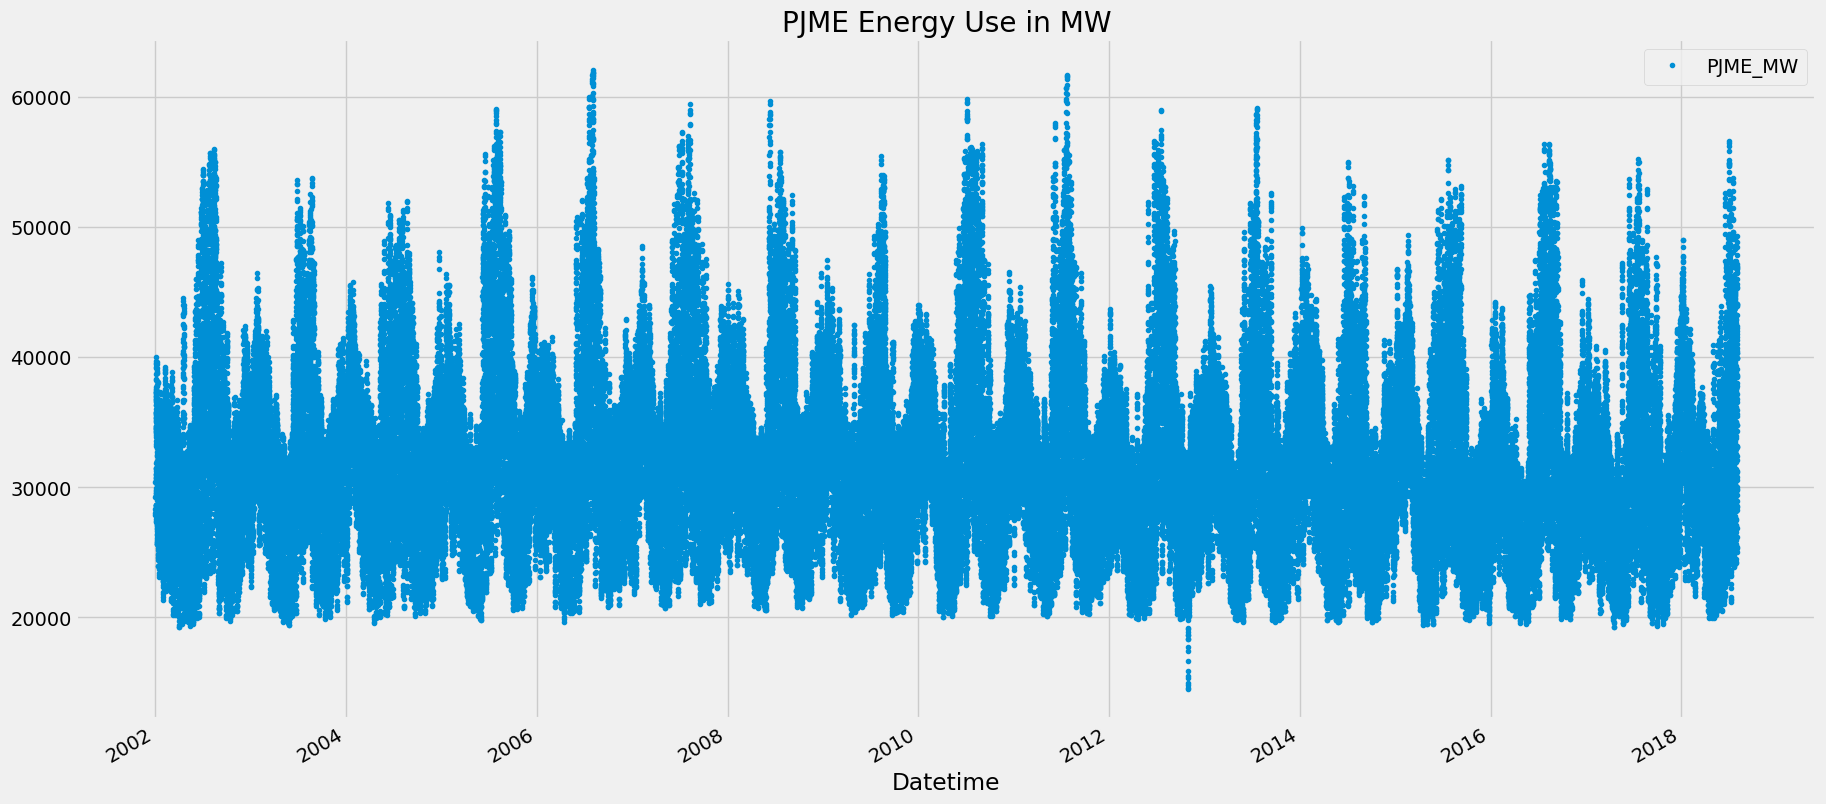

In [179]:
df.plot(style=".", figsize=(20,10), color=color_pal[0], title = "PJME Energy Use in MW")
plt.show()

In [180]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index > '01-01-2015']

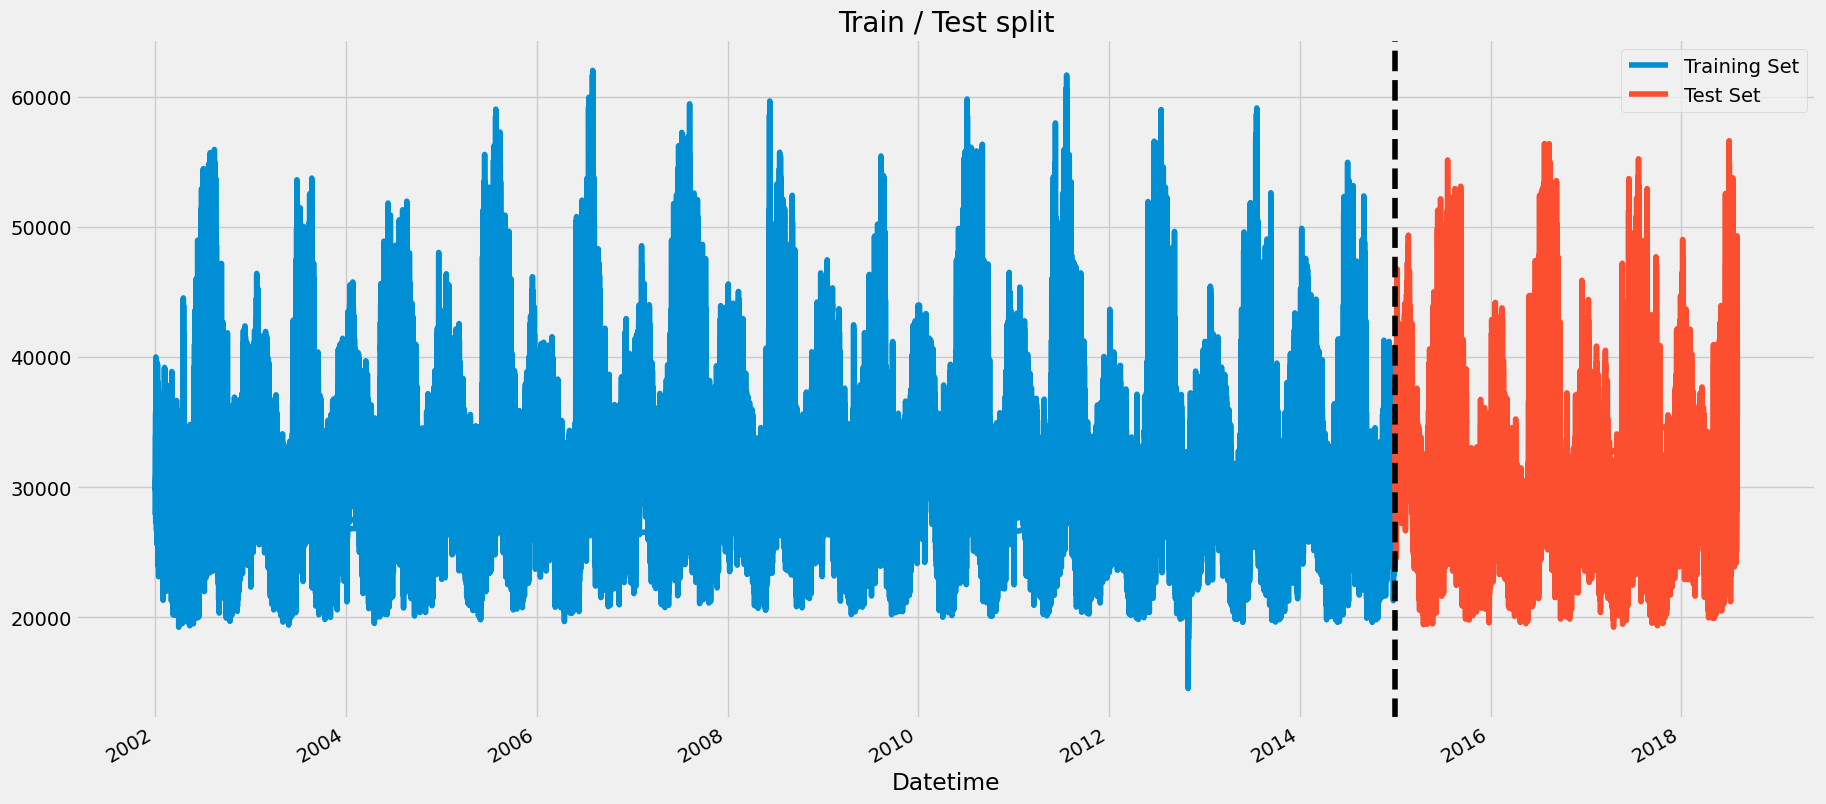

In [181]:
fig, ax = plt.subplots(figsize=(20, 10))
train.plot(ax=ax, label="Training Set", title="Train / Test split")
test.plot(ax=ax, label="Test Set")
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [182]:
def create_features(df):
    """ 
    Create time series features based on the index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df 

In [183]:
df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


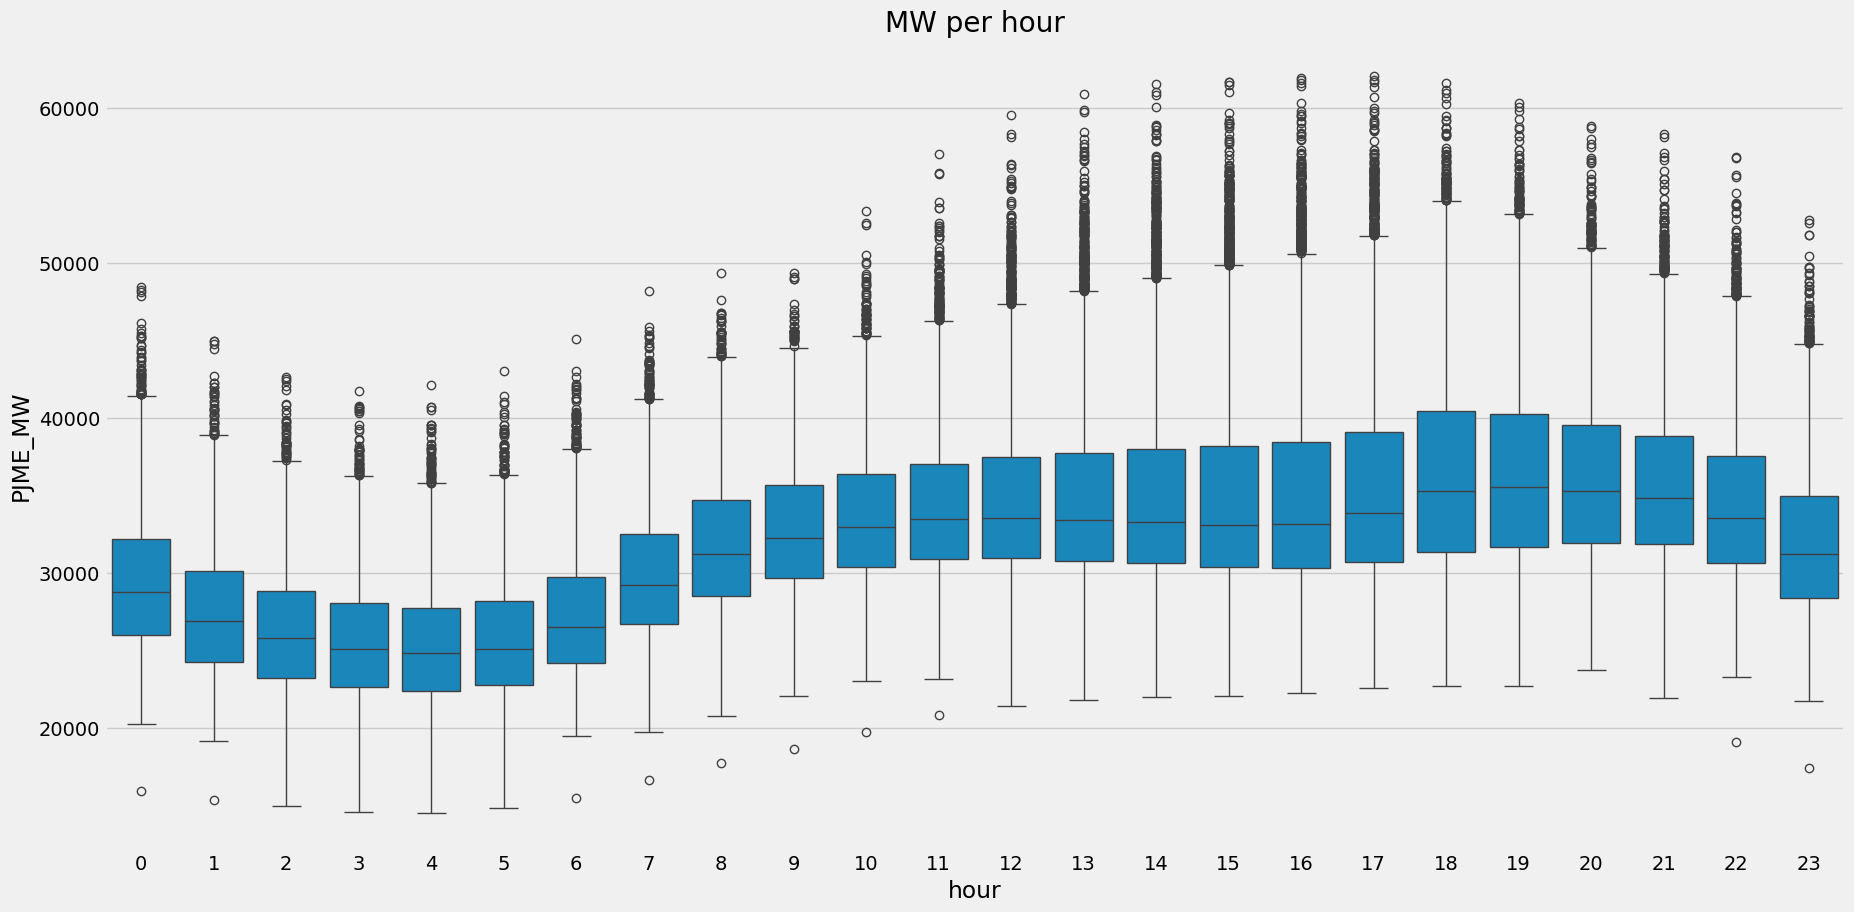

In [184]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW per hour')
plt.show()

/var/folders/mq/1ld9t8tj6577mpr_yq29l3sw0000gn/T/ipykernel_14875/1941156757.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


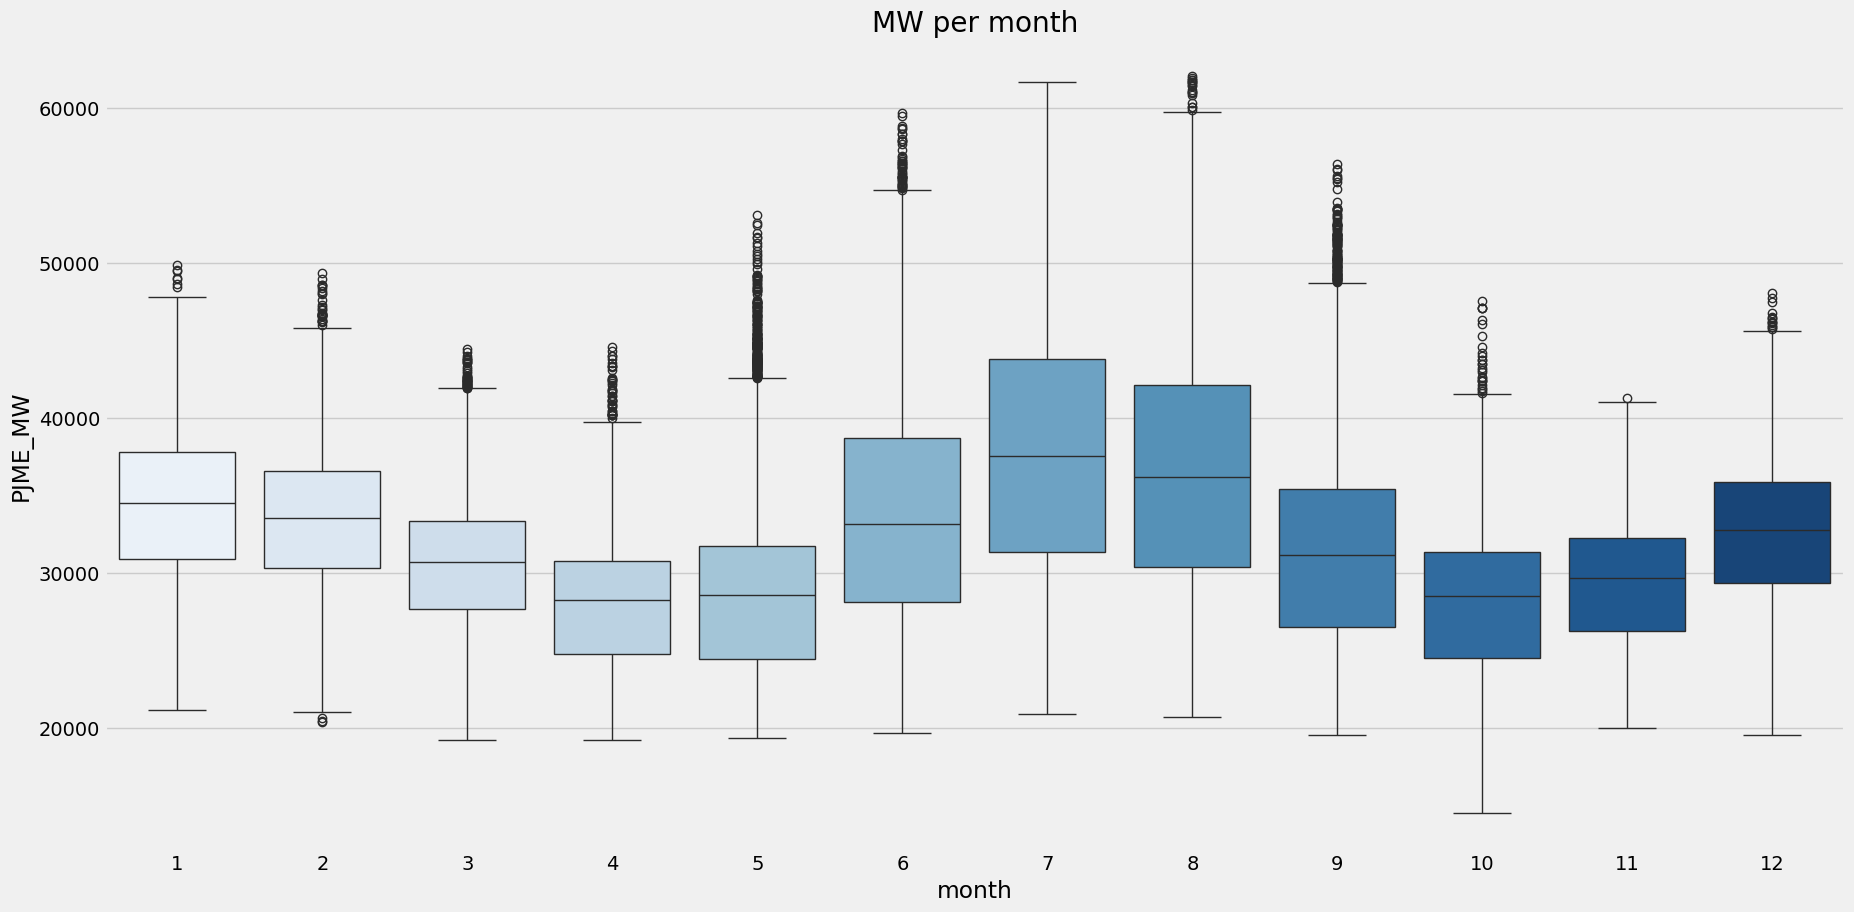

In [185]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW per month')
plt.show()

In [186]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [187]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = ['PJME_MW']

In [188]:
train = create_features(train)
test = create_features(test)

In [189]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [190]:
train = create_features(train)
test = create_features(test)


reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100)

[0]	validation_0-rmse:6447.78573	validation_1-rmse:6517.64446
[100]	validation_0-rmse:6026.49339	validation_1-rmse:6131.17751
[200]	validation_0-rmse:5654.75124	validation_1-rmse:5796.74665
[300]	validation_0-rmse:5326.88030	validation_1-rmse:5505.67974
[400]	validation_0-rmse:5039.56899	validation_1-rmse:5253.29370
[500]	validation_0-rmse:4788.58887	validation_1-rmse:5034.82795
[600]	validation_0-rmse:4565.97498	validation_1-rmse:4847.84252
[700]	validation_0-rmse:4372.19812	validation_1-rmse:4687.18617
[800]	validation_0-rmse:4202.53312	validation_1-rmse:4547.64221
[900]	validation_0-rmse:4055.65261	validation_1-rmse:4427.07596
[999]	validation_0-rmse:3929.32983	validation_1-rmse:4325.41995


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [195]:
feature_importaces = pd.DataFrame(data= reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"])

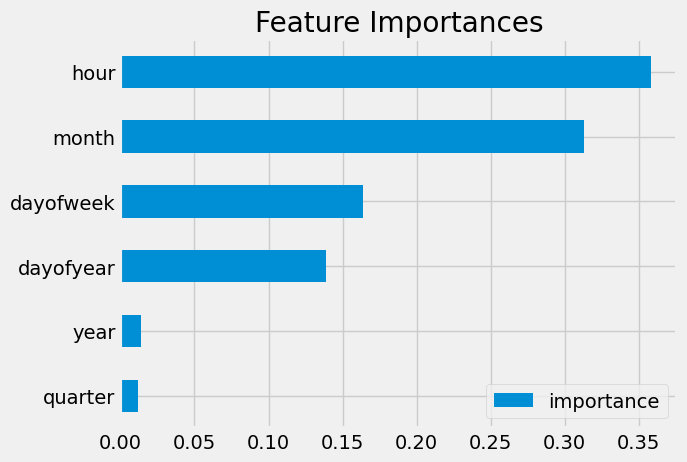

In [197]:
feature_importaces.sort_values('importance').plot(kind='barh', title="Feature Importances")
plt.show()

In [ ]:
test['prediction'] = reg.predict(X_test)